### ***Audio Enhancement Using Upsampling and Downsampling***

Audio downloaded and saved to downloaded_audio.mp3
Loaded audio with sampling rate: 44100 Hz
Audio saved to noisy_audio.wav

Upsampling using linear interpolation...
Audio saved to upsampled_linear.wav

Upsampling using cubic interpolation...
Audio saved to upsampled_cubic.wav

Upsampling using sinc interpolation...
Audio saved to upsampled_sinc.wav

Downsampling with anti-aliasing filter...
Audio saved to downsampled.wav

Upsampling the downsampled signal back to original rate...
Audio saved to upsampled_after_downsampling.wav

Plotting waveforms...


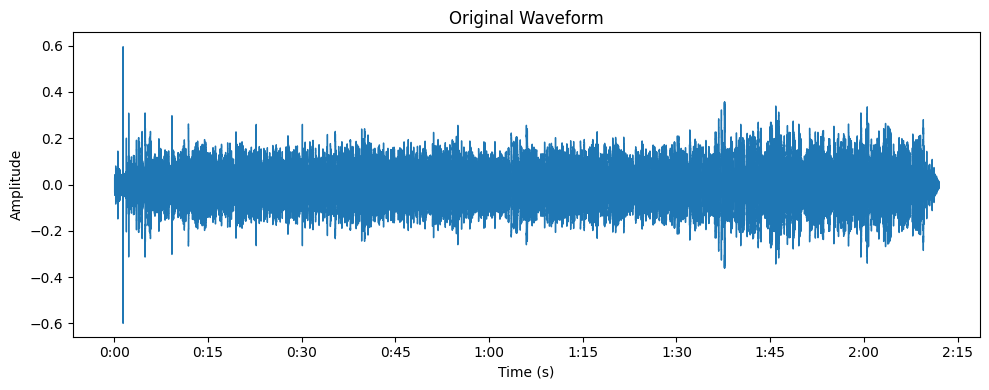

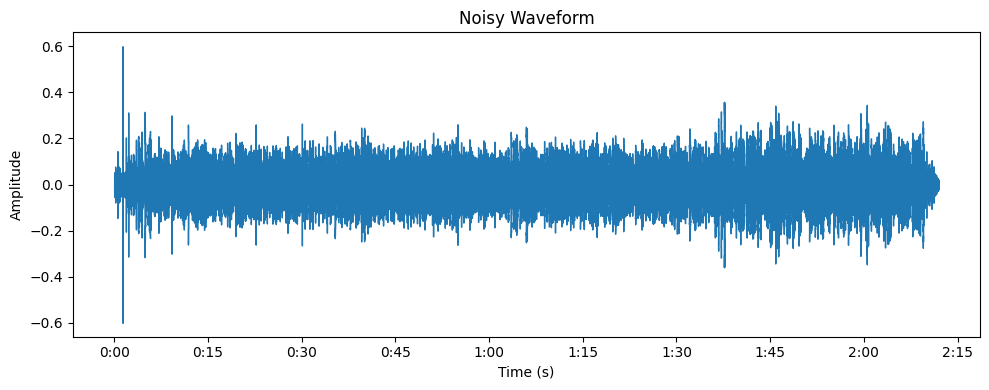

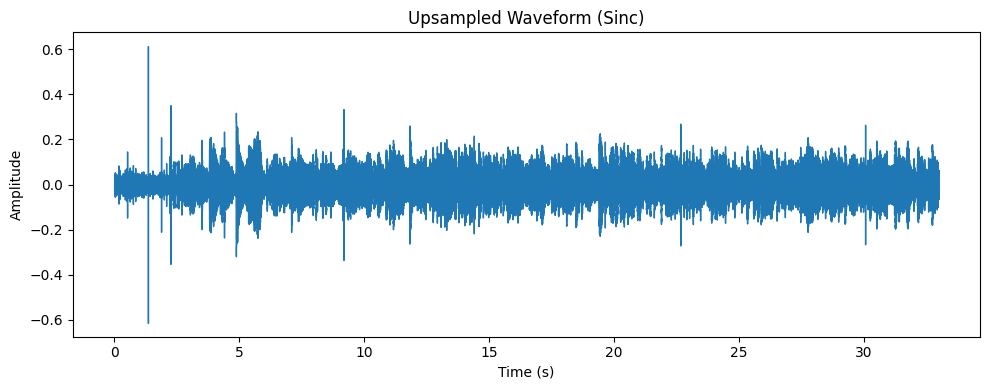

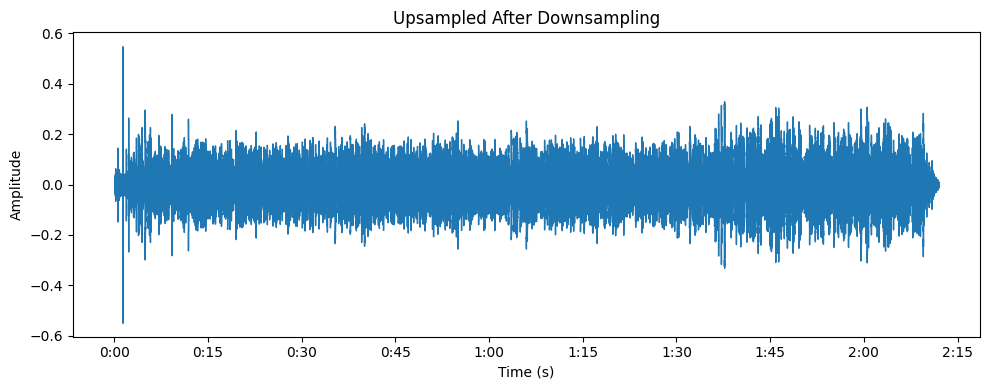


Plotting spectrograms...


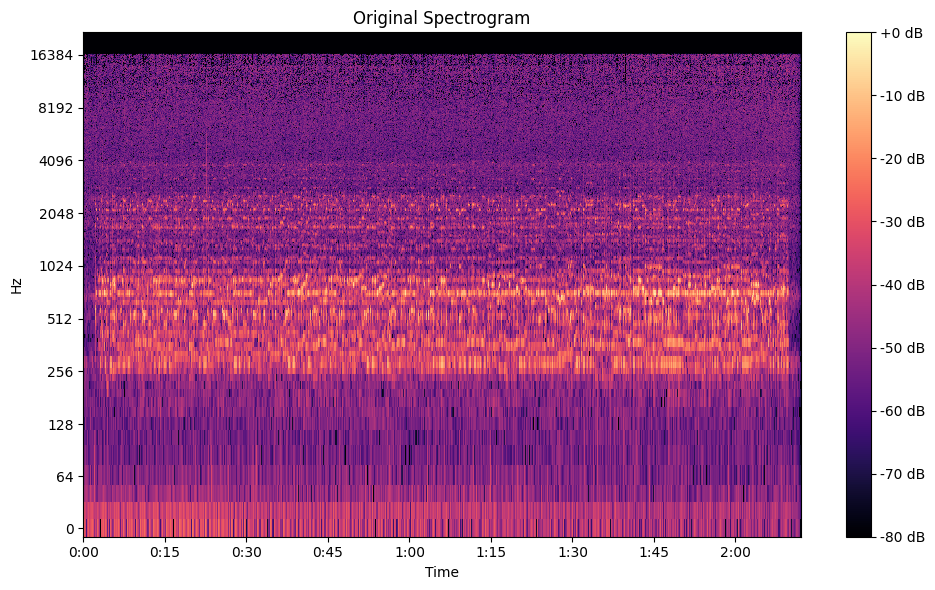

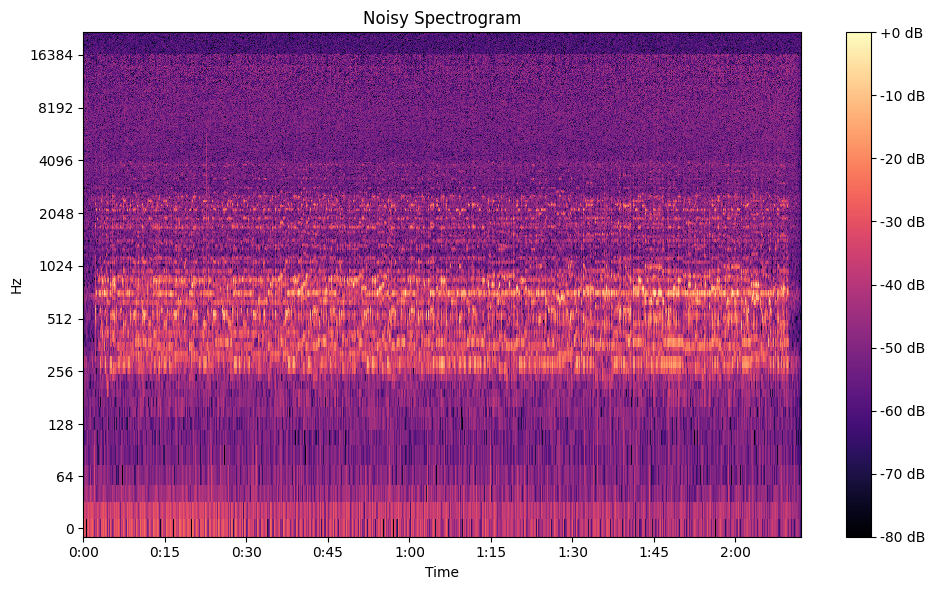

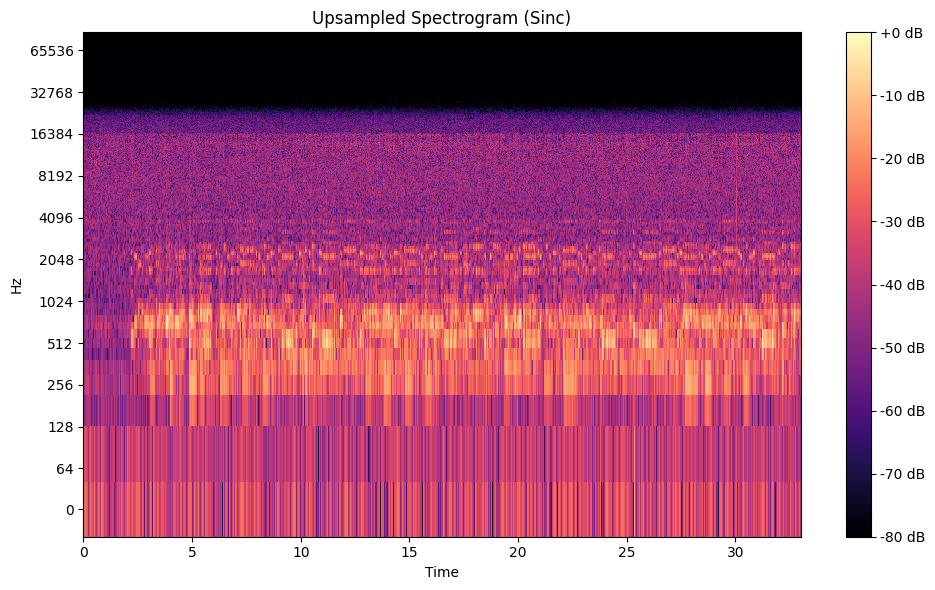

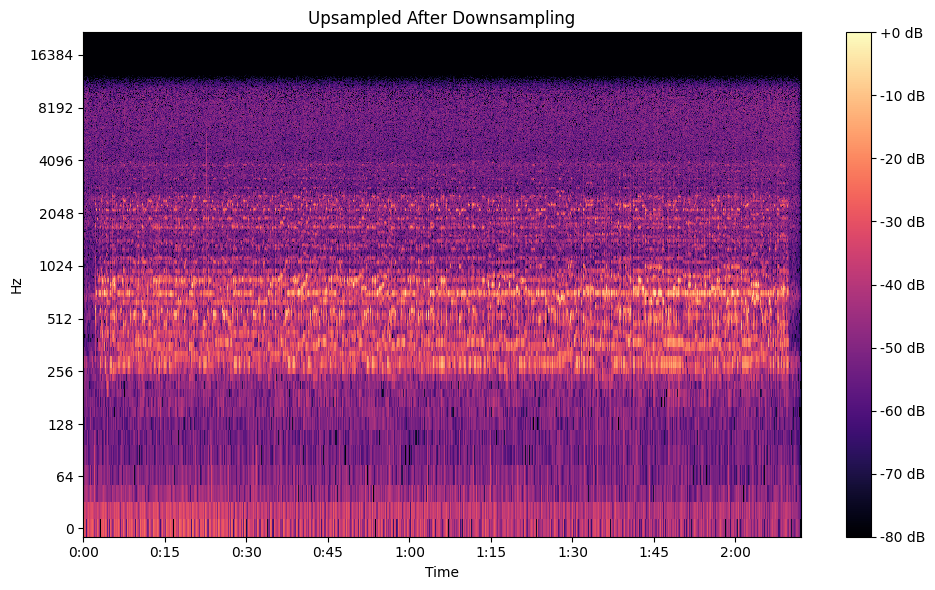


Comparing frequency responses...


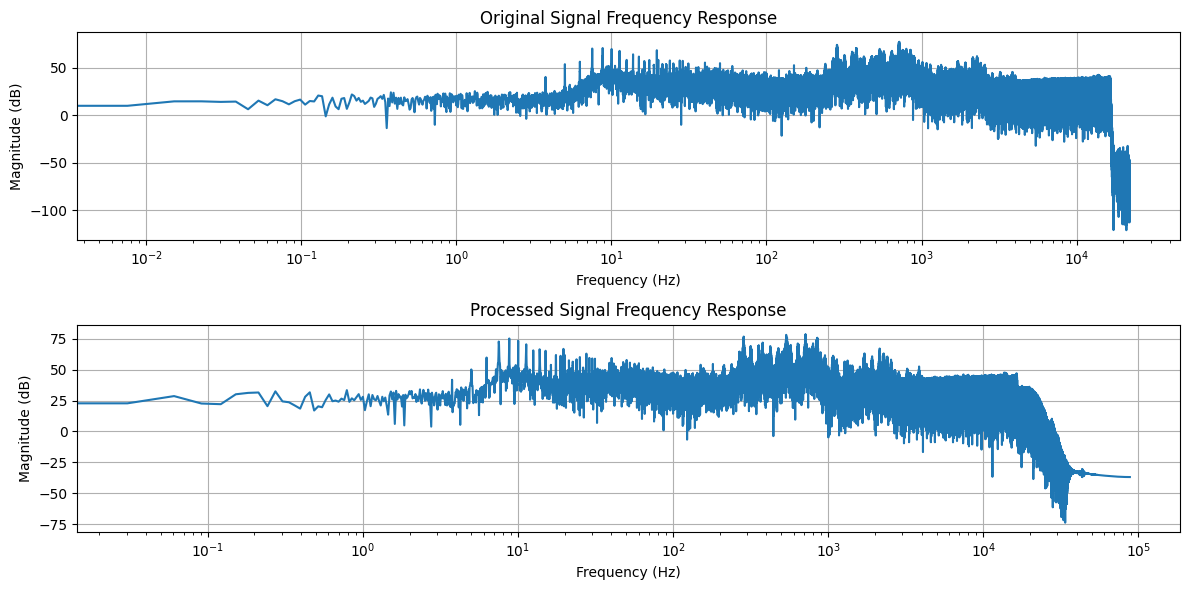


Evaluating linear upsampling...

Evaluation Metrics:
SNR: 24.33 dB
MSE: 0.000006
Original Spectral Centroid: 6819.44 Hz
Processed Spectral Centroid: 5718.14 Hz
Spectral Centroid Change: -1101.31 Hz

Evaluating cubic upsampling...

Evaluation Metrics:
SNR: 30.66 dB
MSE: 0.000001
Original Spectral Centroid: 6819.44 Hz
Processed Spectral Centroid: 6315.59 Hz
Spectral Centroid Change: -503.85 Hz

Evaluating sinc upsampling...

Evaluation Metrics:
SNR: 32.35 dB
MSE: 0.000001
Original Spectral Centroid: 6819.44 Hz
Processed Spectral Centroid: 6536.91 Hz
Spectral Centroid Change: -282.54 Hz

Evaluating downsampling and upsampling back...

Evaluation Metrics:
SNR: 16.63 dB
MSE: 0.000044
Original Spectral Centroid: 5385.41 Hz
Processed Spectral Centroid: 3195.23 Hz
Spectral Centroid Change: -2190.18 Hz

Summary of Evaluation Metrics:
Linear Upsampling - SNR: 24.33 dB, MSE: 0.000006
Cubic Upsampling - SNR: 30.66 dB, MSE: 0.000001
Sinc Upsampling - SNR: 32.35 dB, MSE: 0.000001
Downsampling + Ups

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import librosa.display
import soundfile as sf
import scipy.io.wavfile as wavfile
from scipy.interpolate import interp1d
import os
import requests

class AudioEnhancer:
    """
    A class that implements audio enhancement using upsampling and downsampling techniques.
    Includes methods for different interpolation techniques, anti-aliasing filtering, and
    quality assessment.
    """

    def __init__(self):
        self.original_signal = None
        self.original_sr = None
        self.processed_signal = None
        self.processed_sr = None

    def load_audio(self, file_path):
        """
        Load an audio file.

        Parameters:
        -----------
        file_path : str
            Path to the audio file.

        Returns:
        --------
        audio_data : ndarray
            Audio time series.
        sr : int
            Sampling rate.
        """
        audio_data, sr = librosa.load(file_path, sr=None, mono=True)
        self.original_signal = audio_data
        self.original_sr = sr
        print(f"Loaded audio with sampling rate: {sr} Hz")
        return audio_data, sr

    def add_noise(self, signal, snr_db):
        """
        Add white Gaussian noise to the signal.

        Parameters:
        -----------
        signal : ndarray
            Input signal.
        snr_db : float
            Signal-to-noise ratio in dB.

        Returns:
        --------
        noisy_signal : ndarray
            Signal with added noise.
        """
        # Calculate signal power
        signal_power = np.mean(signal ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / (10 ** (snr_db / 10))

        # Generate noise
        noise = np.random.normal(0, np.sqrt(noise_power), len(signal))

        # Add noise to signal
        noisy_signal = signal + noise

        return noisy_signal

    def design_lowpass_filter(self, cutoff_freq, fs, order=8):
        """
        Design a lowpass filter.

        Parameters:
        -----------
        cutoff_freq : float
            Cutoff frequency of the filter in Hz.
        fs : int
            Sampling rate in Hz.
        order : int
            Filter order.

        Returns:
        --------
        b, a : ndarray
            Filter coefficients.
        """
        nyquist = 0.5 * fs
        normal_cutoff = cutoff_freq / nyquist
        b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply_filter(self, signal_data, b, a):
        """
        Apply filter to signal.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        b, a : ndarray
            Filter coefficients.

        Returns:
        --------
        filtered_signal : ndarray
            Filtered signal.
        """
        return signal.filtfilt(b, a, signal_data)

    def upsample_linear(self, signal_data, sr, target_sr):
        """
        Upsample signal using linear interpolation.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        upsampled_signal : ndarray
            Upsampled signal.
        """
        # Create time arrays for original and target sample rates
        original_time = np.arange(len(signal_data)) / sr
        target_time = np.arange(0, original_time[-1], 1/target_sr)

        # Create interpolation function
        interp_func = interp1d(original_time, signal_data, kind='linear', bounds_error=False, fill_value=0)

        # Apply interpolation
        upsampled_signal = interp_func(target_time)

        self.processed_signal = upsampled_signal
        self.processed_sr = target_sr

        return upsampled_signal

    def upsample_cubic(self, signal_data, sr, target_sr):
        """
        Upsample signal using cubic interpolation.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        upsampled_signal : ndarray
            Upsampled signal.
        """
        # Create time arrays for original and target sample rates
        original_time = np.arange(len(signal_data)) / sr
        target_time = np.arange(0, original_time[-1], 1/target_sr)

        # Create interpolation function
        interp_func = interp1d(original_time, signal_data, kind='cubic', bounds_error=False, fill_value=0)

        # Apply interpolation
        upsampled_signal = interp_func(target_time)

        self.processed_signal = upsampled_signal
        self.processed_sr = target_sr

        return upsampled_signal

    def upsample_sinc(self, signal_data, sr, target_sr):
        """
        Upsample signal using sinc interpolation (ideal lowpass reconstruction).

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        upsampled_signal : ndarray
            Upsampled signal.
        """
        # Calculate upsampling factor
        factor = target_sr / sr

        # First, simple upsampling by inserting zeros
        upsampled_with_zeros = np.zeros(int(len(signal_data) * factor))
        upsampled_with_zeros[::int(factor)] = signal_data

        # Design and apply sinc filter (ideal lowpass)
        cutoff = sr / 2  # Nyquist frequency of original signal
        b, a = self.design_lowpass_filter(cutoff, target_sr)

        # Apply filter and scale by factor to maintain energy
        upsampled_signal = signal.filtfilt(b, a, upsampled_with_zeros) * factor

        self.processed_signal = upsampled_signal
        self.processed_sr = target_sr

        return upsampled_signal

    def downsample(self, signal_data, sr, target_sr):
        """
        Downsample signal with anti-aliasing filter.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        downsampled_signal : ndarray
            Downsampled signal.
        """
        # Design anti-aliasing filter
        cutoff = target_sr / 2  # Nyquist frequency of target sampling rate
        b, a = self.design_lowpass_filter(cutoff, sr)

        # Apply anti-aliasing filter
        filtered_signal = self.apply_filter(signal_data, b, a)

        # Calculate downsampling factor
        factor = sr / target_sr

        # Downsample by picking every Nth sample
        indices = np.arange(0, len(filtered_signal), factor)
        downsampled_signal = filtered_signal[indices.astype(int)]

        self.processed_signal = downsampled_signal
        self.processed_sr = target_sr

        return downsampled_signal

    def calculate_snr(self, original_signal, processed_signal):
        """
        Calculate Signal-to-Noise Ratio (SNR) in dB.

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        processed_signal : ndarray
            Processed signal.

        Returns:
        --------
        snr : float
            SNR in dB.
        """
        # Make sure signals are the same length
        min_length = min(len(original_signal), len(processed_signal))
        original_signal = original_signal[:min_length]
        processed_signal = processed_signal[:min_length]

        # Calculate signal power
        signal_power = np.mean(original_signal ** 2)

        # Calculate noise power (assume difference is noise)
        noise = original_signal - processed_signal
        noise_power = np.mean(noise ** 2)

        # Calculate SNR in dB
        if noise_power == 0:  # To avoid division by zero
            return float('inf')
        snr = 10 * np.log10(signal_power / noise_power)

        return snr

    def calculate_mse(self, original_signal, processed_signal):
        """
        Calculate Mean Squared Error (MSE).

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        processed_signal : ndarray
            Processed signal.

        Returns:
        --------
        mse : float
            Mean Squared Error.
        """
        # Make sure signals are the same length
        min_length = min(len(original_signal), len(processed_signal))
        original_signal = original_signal[:min_length]
        processed_signal = processed_signal[:min_length]

        # Calculate MSE
        mse = np.mean((original_signal - processed_signal) ** 2)

        return mse

    def plot_waveform(self, signal_data, sr, title):
        """
        Plot waveform of the signal.

        Parameters:
        -----------
        signal_data : ndarray
            Signal data.
        sr : int
            Sampling rate.
        title : str
            Plot title.
        """
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(signal_data, sr=sr)
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    def plot_spectrogram(self, signal_data, sr, title):
        """
        Plot spectrogram of the signal.

        Parameters:
        -----------
        signal_data : ndarray
            Signal data.
        sr : int
            Sampling rate.
        title : str
            Plot title.
        """
        plt.figure(figsize=(10, 6))
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal_data)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def save_audio(self, signal_data, sr, file_path):
        """
        Save audio file.

        Parameters:
        -----------
        signal_data : ndarray
            Signal data.
        sr : int
            Sampling rate.
        file_path : str
            Output file path.
        """
        sf.write(file_path, signal_data, sr)
        print(f"Audio saved to {file_path}")

    def compare_frequency_response(self, original_signal, original_sr, processed_signal, processed_sr):
        """
        Compare frequency response of original and processed signals.

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        original_sr : int
            Original sampling rate.
        processed_signal : ndarray
            Processed signal.
        processed_sr : int
            Processed sampling rate.
        """
        # Compute FFT of original signal
        original_fft = np.abs(np.fft.rfft(original_signal))
        original_freqs = np.fft.rfftfreq(len(original_signal), 1/original_sr)

        # Compute FFT of processed signal
        processed_fft = np.abs(np.fft.rfft(processed_signal))
        processed_freqs = np.fft.rfftfreq(len(processed_signal), 1/processed_sr)

        # Plot frequency response
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.semilogx(original_freqs, 20 * np.log10(original_fft + 1e-10))
        plt.title('Original Signal Frequency Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.semilogx(processed_freqs, 20 * np.log10(processed_fft + 1e-10))
        plt.title('Processed Signal Frequency Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def perform_evaluation(self, original_signal, original_sr, processed_signal, processed_sr):
        """
        Perform comprehensive evaluation of the processed audio.

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        original_sr : int
            Original sampling rate.
        processed_signal : ndarray
            Processed signal.
        processed_sr : int
            Processed sampling rate.

        Returns:
        --------
        metrics : dict
            Dictionary containing evaluation metrics.
        """
        # If the sampling rates are different, resample for comparison
        if original_sr != processed_sr:
            # Resample the processed signal to match the original
            resampled_processed = librosa.resample(processed_signal, orig_sr=processed_sr, target_sr=original_sr)
        else:
            resampled_processed = processed_signal

        # Make sure signals are the same length
        min_length = min(len(original_signal), len(resampled_processed))
        original_signal_trimmed = original_signal[:min_length]
        processed_signal_trimmed = resampled_processed[:min_length]

        # Calculate objective metrics
        snr = self.calculate_snr(original_signal_trimmed, processed_signal_trimmed)
        mse = self.calculate_mse(original_signal_trimmed, processed_signal_trimmed)

        # Calculate spectral centroid (measure of brightness)
        original_centroid = librosa.feature.spectral_centroid(y=original_signal_trimmed, sr=original_sr).mean()
        processed_centroid = librosa.feature.spectral_centroid(y=processed_signal_trimmed, sr=original_sr).mean()

        # Store metrics
        metrics = {
            'SNR': snr,
            'MSE': mse,
            'Original Spectral Centroid': original_centroid,
            'Processed Spectral Centroid': processed_centroid,
            'Spectral Centroid Change': processed_centroid - original_centroid
        }

        # Print metrics
        print("\nEvaluation Metrics:")
        print(f"SNR: {snr:.2f} dB")
        print(f"MSE: {mse:.6f}")
        print(f"Original Spectral Centroid: {original_centroid:.2f} Hz")
        print(f"Processed Spectral Centroid: {processed_centroid:.2f} Hz")
        print(f"Spectral Centroid Change: {processed_centroid - original_centroid:.2f} Hz")

        return metrics


def download_audio_from_url(url, save_path):
    """
    Download an audio file from a URL and save it locally.

    Parameters:
    -----------
    url : str
        URL of the audio file.
    save_path : str
        Local path to save the downloaded file.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print(f"Audio downloaded and saved to {save_path}")
    else:
        raise Exception(f"Failed to download audio. Status code: {response.status_code}")


def main():
    """
    Main function to demonstrate the audio enhancement.
    """
    enhancer = AudioEnhancer()

    # URL of the audio file
    audio_url = "https://tile.loc.gov/streaming-services/iiif/service:mbrsrs:mbrsjukebox:dlc_victor_5565_01_b6256_01:dlc_victor_5565_01_b6256_01/full/full/0/full/default.mp3"

    # Local path to save the downloaded audio file
    local_audio_path = "downloaded_audio.mp3"

    # Download the audio file
    download_audio_from_url(audio_url, local_audio_path)

    # Load the audio
    original_signal, original_sr = enhancer.load_audio(local_audio_path)

    # Add some noise to demonstrate enhancement capabilities
    noisy_signal = enhancer.add_noise(original_signal, snr_db=20)

    # Save the noisy signal
    noisy_file = "noisy_audio.wav"
    enhancer.save_audio(noisy_signal, original_sr, noisy_file)

    # Upsample using different techniques
    target_sr_up = original_sr * 4  # Upsample by factor of 4

    print("\nUpsampling using linear interpolation...")
    upsampled_linear = enhancer.upsample_linear(noisy_signal, original_sr, target_sr_up)
    enhancer.save_audio(upsampled_linear, target_sr_up, "upsampled_linear.wav")

    print("\nUpsampling using cubic interpolation...")
    upsampled_cubic = enhancer.upsample_cubic(noisy_signal, original_sr, target_sr_up)
    enhancer.save_audio(upsampled_cubic, target_sr_up, "upsampled_cubic.wav")

    print("\nUpsampling using sinc interpolation...")
    upsampled_sinc = enhancer.upsample_sinc(noisy_signal, original_sr, target_sr_up)
    enhancer.save_audio(upsampled_sinc, target_sr_up, "upsampled_sinc.wav")

    # Downsample with anti-aliasing
    target_sr_down = int(original_sr / 2)  # Downsample by factor of 2

    print("\nDownsampling with anti-aliasing filter...")
    downsampled = enhancer.downsample(original_signal, original_sr, target_sr_down)
    enhancer.save_audio(downsampled, target_sr_down, "downsampled.wav")

    # Now upsample back to original for comparison
    print("\nUpsampling the downsampled signal back to original rate...")
    upsampled_back = enhancer.upsample_sinc(downsampled, target_sr_down, original_sr)
    enhancer.save_audio(upsampled_back, original_sr, "upsampled_after_downsampling.wav")

    # Compare waveforms
    print("\nPlotting waveforms...")
    enhancer.plot_waveform(original_signal, original_sr, "Original Waveform")
    enhancer.plot_waveform(noisy_signal, original_sr, "Noisy Waveform")
    enhancer.plot_waveform(upsampled_sinc[:len(upsampled_sinc)//4], target_sr_up, "Upsampled Waveform (Sinc)")
    enhancer.plot_waveform(upsampled_back, original_sr, "Upsampled After Downsampling")

    # Compare spectrograms
    print("\nPlotting spectrograms...")
    enhancer.plot_spectrogram(original_signal, original_sr, "Original Spectrogram")
    enhancer.plot_spectrogram(noisy_signal, original_sr, "Noisy Spectrogram")
    enhancer.plot_spectrogram(upsampled_sinc[:len(upsampled_sinc)//4], target_sr_up, "Upsampled Spectrogram (Sinc)")
    enhancer.plot_spectrogram(upsampled_back, original_sr, "Upsampled After Downsampling")

    # Compare frequency responses
    print("\nComparing frequency responses...")
    enhancer.compare_frequency_response(original_signal, original_sr, upsampled_sinc[:len(upsampled_sinc)//4], target_sr_up)

    # Perform evaluations
    print("\nEvaluating linear upsampling...")
    linear_metrics = enhancer.perform_evaluation(noisy_signal, original_sr, upsampled_linear[:len(upsampled_linear)//4], target_sr_up)

    print("\nEvaluating cubic upsampling...")
    cubic_metrics = enhancer.perform_evaluation(noisy_signal, original_sr, upsampled_cubic[:len(upsampled_cubic)//4], target_sr_up)

    print("\nEvaluating sinc upsampling...")
    sinc_metrics = enhancer.perform_evaluation(noisy_signal, original_sr, upsampled_sinc[:len(upsampled_sinc)//4], target_sr_up)

    print("\nEvaluating downsampling and upsampling back...")
    down_up_metrics = enhancer.perform_evaluation(original_signal, original_sr, upsampled_back, original_sr)

    # Summary
    print("\nSummary of Evaluation Metrics:")
    print(f"Linear Upsampling - SNR: {linear_metrics['SNR']:.2f} dB, MSE: {linear_metrics['MSE']:.6f}")
    print(f"Cubic Upsampling - SNR: {cubic_metrics['SNR']:.2f} dB, MSE: {cubic_metrics['MSE']:.6f}")
    print(f"Sinc Upsampling - SNR: {sinc_metrics['SNR']:.2f} dB, MSE: {sinc_metrics['MSE']:.6f}")
    print(f"Downsampling + Upsampling - SNR: {down_up_metrics['SNR']:.2f} dB, MSE: {down_up_metrics['MSE']:.6f}")

    print("\nConclusion:")
    best_snr = max(linear_metrics['SNR'], cubic_metrics['SNR'], sinc_metrics['SNR'])
    if best_snr == linear_metrics['SNR']:
        best_method = "Linear interpolation"
    elif best_snr == cubic_metrics['SNR']:
        best_method = "Cubic interpolation"
    else:
        best_method = "Sinc interpolation"

    print(f"Best upsampling method based on SNR: {best_method} with SNR of {best_snr:.2f} dB")


if __name__ == "__main__":
    main()

# **Evaluation of Audio enhamncement**


Audio downloaded and saved to results/downloaded_audio.mp3

Processing file: results/downloaded_audio.mp3
Loaded audio with sampling rate: 44100 Hz

Adding noise at SNR: 30 dB
Audio saved to results/downloaded_audio_noisy_30db.wav
Upsampling with linear interpolation (factor: 2)...
Audio saved to results/downloaded_audio_noisy_30db_up_linear_x2.wav

Evaluation Metrics:
SNR: 28.05 dB
MSE: 0.000003
Original Spectral Centroid: 5805.30 Hz
Processed Spectral Centroid: 5165.11 Hz
Spectral Centroid Change: -640.18 Hz
Upsampling with cubic interpolation (factor: 2)...
Audio saved to results/downloaded_audio_noisy_30db_up_cubic_x2.wav

Evaluation Metrics:
SNR: 38.02 dB
MSE: 0.000000
Original Spectral Centroid: 5805.30 Hz
Processed Spectral Centroid: 5562.30 Hz
Spectral Centroid Change: -243.00 Hz
Upsampling with sinc interpolation (factor: 2)...
Audio saved to results/downloaded_audio_noisy_30db_up_sinc_x2.wav

Evaluation Metrics:
SNR: 42.91 dB
MSE: 0.000000
Original Spectral Centroid: 5805.30

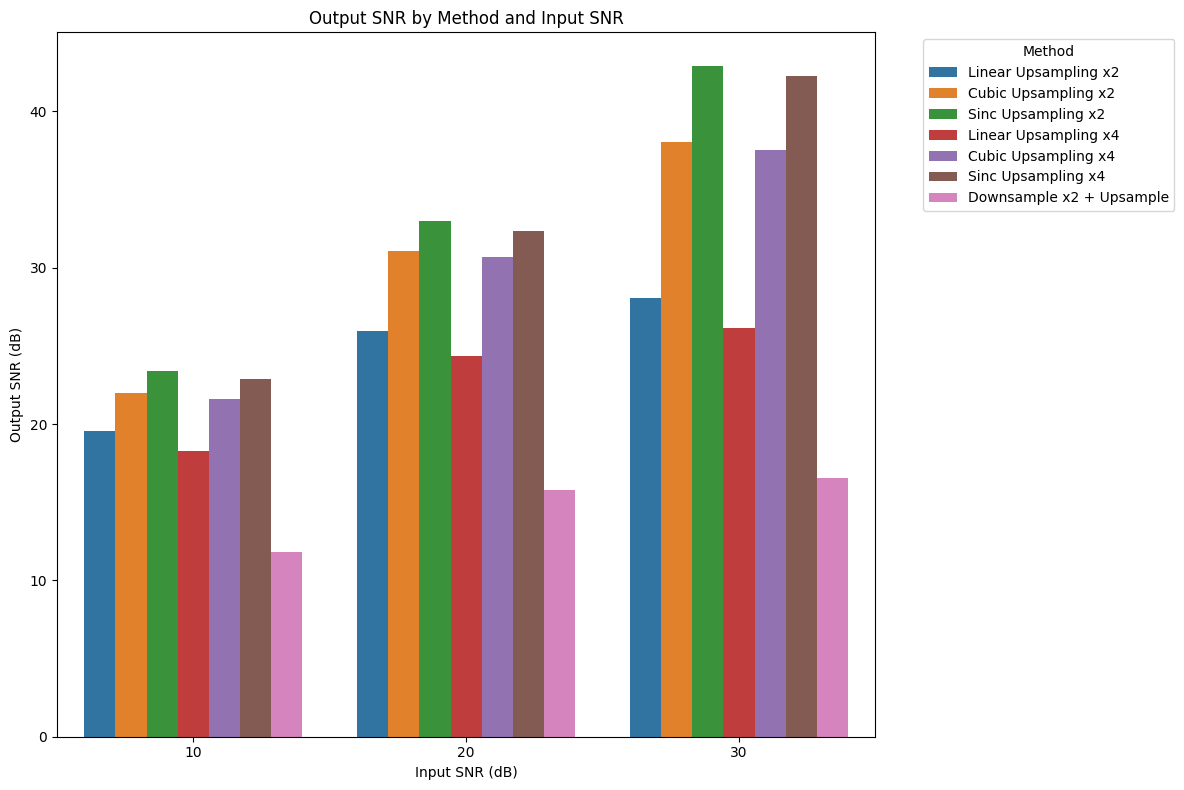

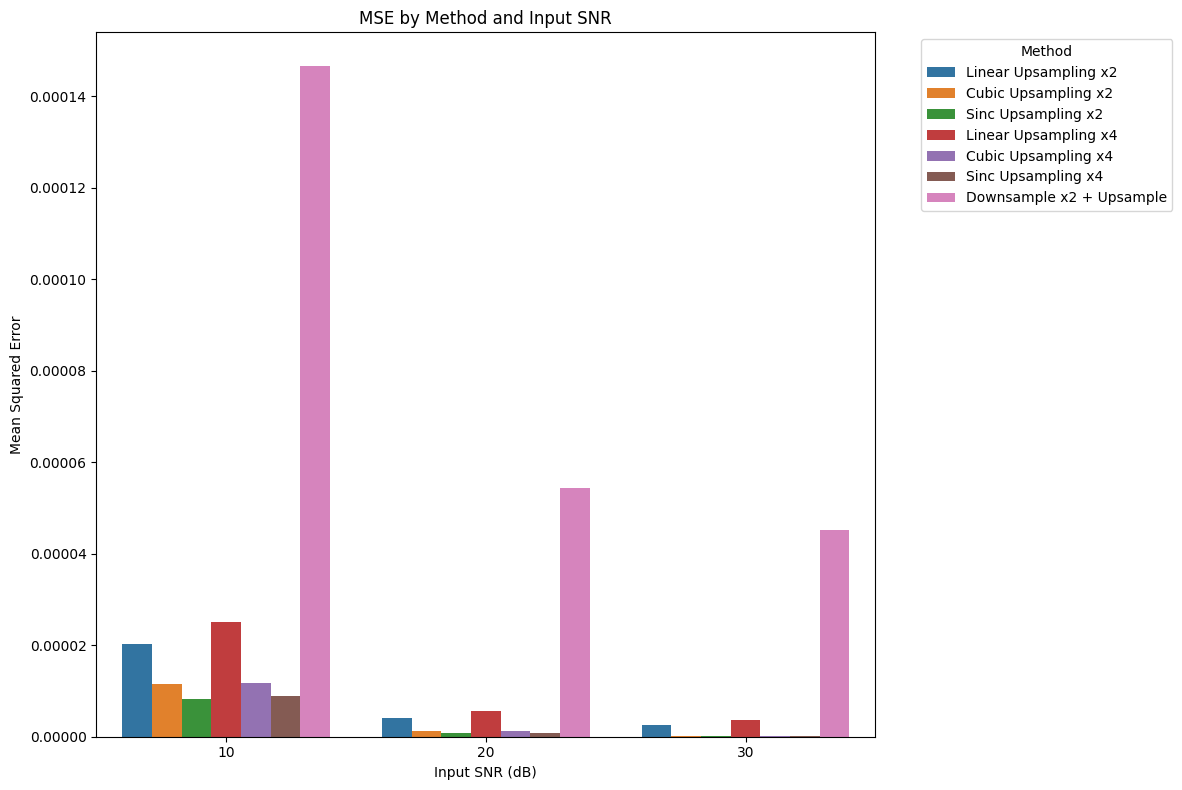

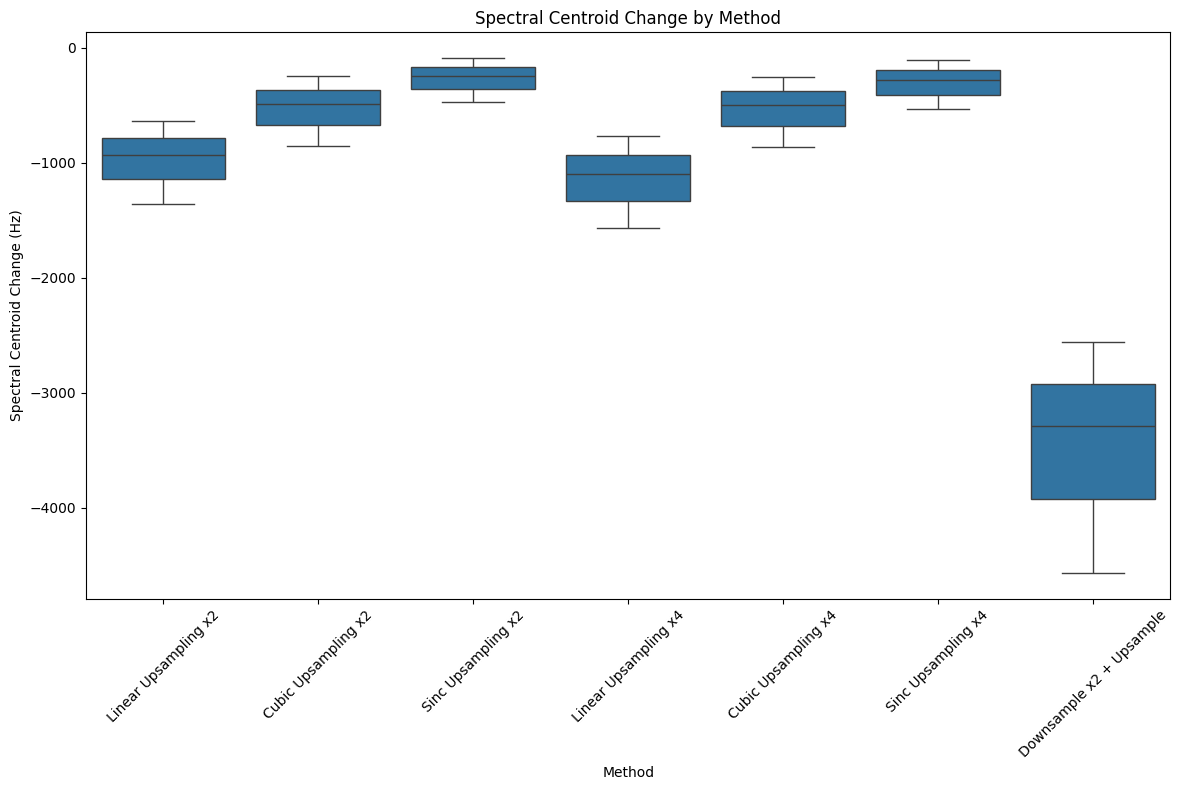

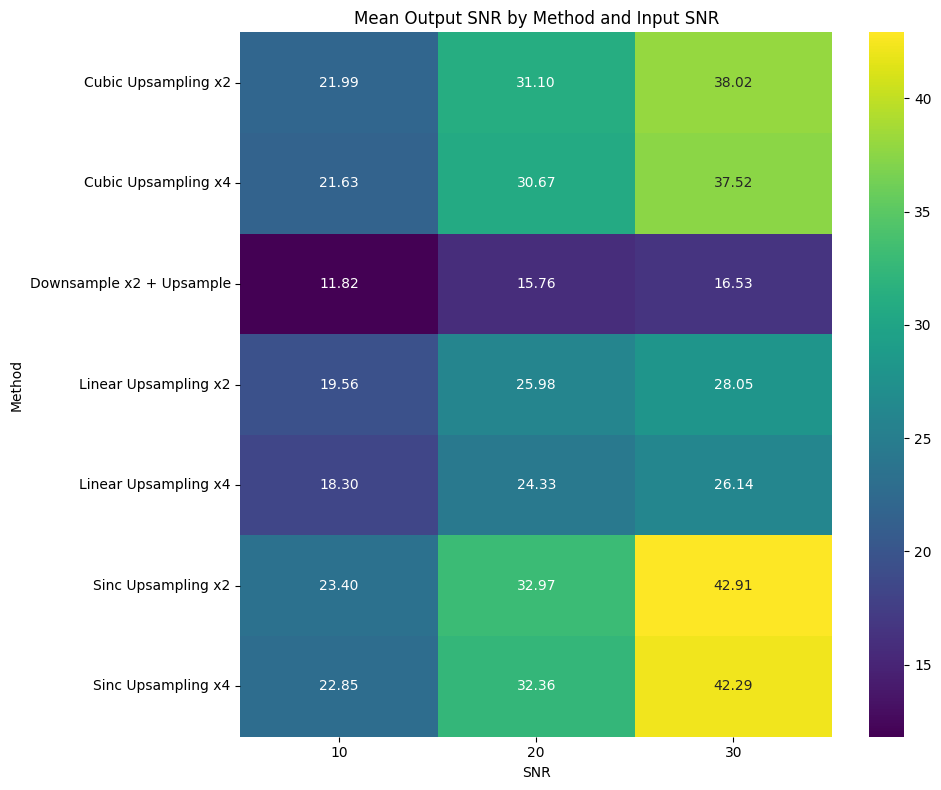

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d  # Add this import
import librosa
import librosa.display
import soundfile as sf
import os
import pandas as pd
import seaborn as sns
import requests

class AudioEnhancer:
    """
    A class that implements audio enhancement using upsampling and downsampling techniques.
    Includes methods for different interpolation techniques, anti-aliasing filtering, and
    quality assessment.
    """

    def __init__(self):
        self.original_signal = None
        self.original_sr = None
        self.processed_signal = None
        self.processed_sr = None

    def load_audio(self, file_path):
        """
        Load an audio file.

        Parameters:
        -----------
        file_path : str
            Path to the audio file.

        Returns:
        --------
        audio_data : ndarray
            Audio time series.
        sr : int
            Sampling rate.
        """
        audio_data, sr = librosa.load(file_path, sr=None, mono=True)
        self.original_signal = audio_data
        self.original_sr = sr
        print(f"Loaded audio with sampling rate: {sr} Hz")
        return audio_data, sr

    def add_noise(self, signal, snr_db):
        """
        Add white Gaussian noise to the signal.

        Parameters:
        -----------
        signal : ndarray
            Input signal.
        snr_db : float
            Signal-to-noise ratio in dB.

        Returns:
        --------
        noisy_signal : ndarray
            Signal with added noise.
        """
        # Calculate signal power
        signal_power = np.mean(signal ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / (10 ** (snr_db / 10))

        # Generate noise
        noise = np.random.normal(0, np.sqrt(noise_power), len(signal))

        # Add noise to signal
        noisy_signal = signal + noise

        return noisy_signal

    def design_lowpass_filter(self, cutoff_freq, fs, order=8):
        """
        Design a lowpass filter.

        Parameters:
        -----------
        cutoff_freq : float
            Cutoff frequency of the filter in Hz.
        fs : int
            Sampling rate in Hz.
        order : int
            Filter order.

        Returns:
        --------
        b, a : ndarray
            Filter coefficients.
        """
        nyquist = 0.5 * fs
        normal_cutoff = cutoff_freq / nyquist
        b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply_filter(self, signal_data, b, a):
        """
        Apply filter to signal.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        b, a : ndarray
            Filter coefficients.

        Returns:
        --------
        filtered_signal : ndarray
            Filtered signal.
        """
        return signal.filtfilt(b, a, signal_data)

    def upsample_linear(self, signal_data, sr, target_sr):
        """
        Upsample signal using linear interpolation.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        upsampled_signal : ndarray
            Upsampled signal.
        """
        # Create time arrays for original and target sample rates
        original_time = np.arange(len(signal_data)) / sr
        target_time = np.arange(0, original_time[-1], 1/target_sr)

        # Create interpolation function
        interp_func = interp1d(original_time, signal_data, kind='linear', bounds_error=False, fill_value=0)

        # Apply interpolation
        upsampled_signal = interp_func(target_time)

        self.processed_signal = upsampled_signal
        self.processed_sr = target_sr

        return upsampled_signal

    def upsample_cubic(self, signal_data, sr, target_sr):
        """
        Upsample signal using cubic interpolation.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        upsampled_signal : ndarray
            Upsampled signal.
        """
        # Create time arrays for original and target sample rates
        original_time = np.arange(len(signal_data)) / sr
        target_time = np.arange(0, original_time[-1], 1/target_sr)

        # Create interpolation function
        interp_func = interp1d(original_time, signal_data, kind='cubic', bounds_error=False, fill_value=0)

        # Apply interpolation
        upsampled_signal = interp_func(target_time)

        self.processed_signal = upsampled_signal
        self.processed_sr = target_sr

        return upsampled_signal

    def upsample_sinc(self, signal_data, sr, target_sr):
        """
        Upsample signal using sinc interpolation (ideal lowpass reconstruction).

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        upsampled_signal : ndarray
            Upsampled signal.
        """
        # Calculate upsampling factor
        factor = target_sr / sr

        # First, simple upsampling by inserting zeros
        upsampled_with_zeros = np.zeros(int(len(signal_data) * factor))
        upsampled_with_zeros[::int(factor)] = signal_data

        # Design and apply sinc filter (ideal lowpass)
        cutoff = sr / 2  # Nyquist frequency of original signal
        b, a = self.design_lowpass_filter(cutoff, target_sr)

        # Apply filter and scale by factor to maintain energy
        upsampled_signal = signal.filtfilt(b, a, upsampled_with_zeros) * factor

        self.processed_signal = upsampled_signal
        self.processed_sr = target_sr

        return upsampled_signal

    def downsample(self, signal_data, sr, target_sr):
        """
        Downsample signal with anti-aliasing filter.

        Parameters:
        -----------
        signal_data : ndarray
            Input signal.
        sr : int
            Original sampling rate.
        target_sr : int
            Target sampling rate.

        Returns:
        --------
        downsampled_signal : ndarray
            Downsampled signal.
        """
        # Design anti-aliasing filter
        cutoff = target_sr / 2  # Nyquist frequency of target sampling rate
        b, a = self.design_lowpass_filter(cutoff, sr)

        # Apply anti-aliasing filter
        filtered_signal = self.apply_filter(signal_data, b, a)

        # Calculate downsampling factor
        factor = sr / target_sr

        # Downsample by picking every Nth sample
        indices = np.arange(0, len(filtered_signal), factor)
        downsampled_signal = filtered_signal[indices.astype(int)]

        self.processed_signal = downsampled_signal
        self.processed_sr = target_sr

        return downsampled_signal

    def calculate_snr(self, original_signal, processed_signal):
        """
        Calculate Signal-to-Noise Ratio (SNR) in dB.

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        processed_signal : ndarray
            Processed signal.

        Returns:
        --------
        snr : float
            SNR in dB.
        """
        # Make sure signals are the same length
        min_length = min(len(original_signal), len(processed_signal))
        original_signal = original_signal[:min_length]
        processed_signal = processed_signal[:min_length]

        # Calculate signal power
        signal_power = np.mean(original_signal ** 2)

        # Calculate noise power (assume difference is noise)
        noise = original_signal - processed_signal
        noise_power = np.mean(noise ** 2)

        # Calculate SNR in dB
        if noise_power == 0:  # To avoid division by zero
            return float('inf')
        snr = 10 * np.log10(signal_power / noise_power)

        return snr

    def calculate_mse(self, original_signal, processed_signal):
        """
        Calculate Mean Squared Error (MSE).

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        processed_signal : ndarray
            Processed signal.

        Returns:
        --------
        mse : float
            Mean Squared Error.
        """
        # Make sure signals are the same length
        min_length = min(len(original_signal), len(processed_signal))
        original_signal = original_signal[:min_length]
        processed_signal = processed_signal[:min_length]

        # Calculate MSE
        mse = np.mean((original_signal - processed_signal) ** 2)

        return mse

    def plot_waveform(self, signal_data, sr, title):
        """
        Plot waveform of the signal.

        Parameters:
        -----------
        signal_data : ndarray
            Signal data.
        sr : int
            Sampling rate.
        title : str
            Plot title.
        """
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(signal_data, sr=sr)
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

    def plot_spectrogram(self, signal_data, sr, title):
        """
        Plot spectrogram of the signal.

        Parameters:
        -----------
        signal_data : ndarray
            Signal data.
        sr : int
            Sampling rate.
        title : str
            Plot title.
        """
        plt.figure(figsize=(10, 6))
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal_data)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def save_audio(self, signal_data, sr, file_path):
        """
        Save audio file.

        Parameters:
        -----------
        signal_data : ndarray
            Signal data.
        sr : int
            Sampling rate.
        file_path : str
            Output file path.
        """
        sf.write(file_path, signal_data, sr)
        print(f"Audio saved to {file_path}")

    def compare_frequency_response(self, original_signal, original_sr, processed_signal, processed_sr):
        """
        Compare frequency response of original and processed signals.

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        original_sr : int
            Original sampling rate.
        processed_signal : ndarray
            Processed signal.
        processed_sr : int
            Processed sampling rate.
        """
        # Compute FFT of original signal
        original_fft = np.abs(np.fft.rfft(original_signal))
        original_freqs = np.fft.rfftfreq(len(original_signal), 1/original_sr)

        # Compute FFT of processed signal
        processed_fft = np.abs(np.fft.rfft(processed_signal))
        processed_freqs = np.fft.rfftfreq(len(processed_signal), 1/processed_sr)

        # Plot frequency response
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.semilogx(original_freqs, 20 * np.log10(original_fft + 1e-10))
        plt.title('Original Signal Frequency Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid(True)

        plt.subplot(2, 1, 2)
        plt.semilogx(processed_freqs, 20 * np.log10(processed_fft + 1e-10))
        plt.title('Processed Signal Frequency Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def perform_evaluation(self, original_signal, original_sr, processed_signal, processed_sr):
        """
        Perform comprehensive evaluation of the processed audio.

        Parameters:
        -----------
        original_signal : ndarray
            Original signal.
        original_sr : int
            Original sampling rate.
        processed_signal : ndarray
            Processed signal.
        processed_sr : int
            Processed sampling rate.

        Returns:
        --------
        metrics : dict
            Dictionary containing evaluation metrics.
        """
        # If the sampling rates are different, resample for comparison
        if original_sr != processed_sr:
            # Resample the processed signal to match the original
            resampled_processed = librosa.resample(processed_signal, orig_sr=processed_sr, target_sr=original_sr)
        else:
            resampled_processed = processed_signal

        # Make sure signals are the same length
        min_length = min(len(original_signal), len(resampled_processed))
        original_signal_trimmed = original_signal[:min_length]
        processed_signal_trimmed = resampled_processed[:min_length]

        # Calculate objective metrics
        snr = self.calculate_snr(original_signal_trimmed, processed_signal_trimmed)
        mse = self.calculate_mse(original_signal_trimmed, processed_signal_trimmed)

        # Calculate spectral centroid (measure of brightness)
        original_centroid = librosa.feature.spectral_centroid(y=original_signal_trimmed, sr=original_sr).mean()
        processed_centroid = librosa.feature.spectral_centroid(y=processed_signal_trimmed, sr=original_sr).mean()

        # Store metrics
        metrics = {
            'SNR': snr,
            'MSE': mse,
            'Original Spectral Centroid': original_centroid,
            'Processed Spectral Centroid': processed_centroid,
            'Spectral Centroid Change': processed_centroid - original_centroid
        }

        # Print metrics
        print("\nEvaluation Metrics:")
        print(f"SNR: {snr:.2f} dB")
        print(f"MSE: {mse:.6f}")
        print(f"Original Spectral Centroid: {original_centroid:.2f} Hz")
        print(f"Processed Spectral Centroid: {processed_centroid:.2f} Hz")
        print(f"Spectral Centroid Change: {processed_centroid - original_centroid:.2f} Hz")

        return metrics


def download_audio_from_url(url, save_path):
    """
    Download an audio file from a URL and save it locally.

    Parameters:
    -----------
    url : str
        URL of the audio file.
    save_path : str
        Local path to save the downloaded file.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print(f"Audio downloaded and saved to {save_path}")
    else:
        raise Exception(f"Failed to download audio. Status code: {response.status_code}")


def run_comparative_analysis(audio_files=None, generate_synthetic=True, audio_url=None):
    """
    Run a comparative analysis of different audio enhancement techniques.

    Parameters:
    -----------
    audio_files : list
        List of paths to audio files.
    generate_synthetic : bool
        Whether to generate synthetic test signals.
    audio_url : str
        URL of the audio file to download and process.
    """
    enhancer = AudioEnhancer()

    # List to store results
    results = []

    # Create output directory if it doesn't exist
    os.makedirs("results", exist_ok=True)

    # Download and process audio from URL if provided
    if audio_url:
        print(f"\nDownloading audio from URL: {audio_url}")
        local_audio_path = "results/downloaded_audio.mp3"
        download_audio_from_url(audio_url, local_audio_path)
        process_file(local_audio_path, enhancer, results)

    # Process audio files if provided
    if audio_files:
        for file_path in audio_files:
            process_file(file_path, enhancer, results)

    # Generate synthetic signals if requested
    if generate_synthetic:
        print("\nGenerating and processing synthetic signals...")

        # Different types of synthetic signals
        signal_types = [
            ("sine_sweep", generate_sine_sweep),
            ("white_noise", generate_white_noise),
            ("impulse_train", generate_impulse_train)
        ]

        for signal_name, generator_func in signal_types:
            signal_data, sr = generator_func()
            file_path = f"results/{signal_name}.wav"
            sf.write(file_path, signal_data, sr)
            process_file(file_path, enhancer, results)

    # Convert results to DataFrame and analyze
    if results:
        analyze_results(results)


def process_file(file_path, enhancer, results):
    """
    Process a single audio file with different enhancement techniques.

    Parameters:
    -----------
    file_path : str
        Path to the audio file.
    enhancer : AudioEnhancer
        Instance of AudioEnhancer class.
    results : list
        List to append results to.
    """
    print(f"\nProcessing file: {file_path}")
    filename = os.path.basename(file_path)
    base_name = os.path.splitext(filename)[0]

    # Load audio
    original_signal, original_sr = enhancer.load_audio(file_path)

    # Add noise
    snr_levels = [30, 20, 10]

    for snr_db in snr_levels:
        print(f"\nAdding noise at SNR: {snr_db} dB")
        noisy_signal = enhancer.add_noise(original_signal, snr_db)
        noisy_file = f"results/{base_name}_noisy_{snr_db}db.wav"
        enhancer.save_audio(noisy_signal, original_sr, noisy_file)

        # Calculate target sample rates
        upsample_factors = [2, 4]
        downsample_factors = [2]

        # Upsampling tests
        for factor in upsample_factors:
            target_sr = original_sr * factor

            # Linear interpolation
            print(f"Upsampling with linear interpolation (factor: {factor})...")
            upsampled_linear = enhancer.upsample_linear(noisy_signal, original_sr, target_sr)
            upsampled_linear_file = f"results/{base_name}_noisy_{snr_db}db_up_linear_x{factor}.wav"
            enhancer.save_audio(upsampled_linear, target_sr, upsampled_linear_file)
            metrics_linear = enhancer.perform_evaluation(noisy_signal, original_sr, upsampled_linear[:len(upsampled_linear)//factor], target_sr)
            results.append({
                'File': base_name,
                'SNR': snr_db,
                'Method': f'Linear Upsampling x{factor}',
                'Output SNR': metrics_linear['SNR'],
                'MSE': metrics_linear['MSE'],
                'Spectral Centroid Change': metrics_linear['Spectral Centroid Change']
            })

            # Cubic interpolation
            print(f"Upsampling with cubic interpolation (factor: {factor})...")
            upsampled_cubic = enhancer.upsample_cubic(noisy_signal, original_sr, target_sr)
            upsampled_cubic_file = f"results/{base_name}_noisy_{snr_db}db_up_cubic_x{factor}.wav"
            enhancer.save_audio(upsampled_cubic, target_sr, upsampled_cubic_file)
            metrics_cubic = enhancer.perform_evaluation(noisy_signal, original_sr, upsampled_cubic[:len(upsampled_cubic)//factor], target_sr)
            results.append({
                'File': base_name,
                'SNR': snr_db,
                'Method': f'Cubic Upsampling x{factor}',
                'Output SNR': metrics_cubic['SNR'],
                'MSE': metrics_cubic['MSE'],
                'Spectral Centroid Change': metrics_cubic['Spectral Centroid Change']
            })

            # Sinc interpolation
            print(f"Upsampling with sinc interpolation (factor: {factor})...")
            upsampled_sinc = enhancer.upsample_sinc(noisy_signal, original_sr, target_sr)
            upsampled_sinc_file = f"results/{base_name}_noisy_{snr_db}db_up_sinc_x{factor}.wav"
            enhancer.save_audio(upsampled_sinc, target_sr, upsampled_sinc_file)
            metrics_sinc = enhancer.perform_evaluation(noisy_signal, original_sr, upsampled_sinc[:len(upsampled_sinc)//factor], target_sr)
            results.append({
                'File': base_name,
                'SNR': snr_db,
                'Method': f'Sinc Upsampling x{factor}',
                'Output SNR': metrics_sinc['SNR'],
                'MSE': metrics_sinc['MSE'],
                'Spectral Centroid Change': metrics_sinc['Spectral Centroid Change']
            })

        # Downsampling test
        for factor in downsample_factors:
            target_sr_down = int(original_sr / factor)

            print(f"Downsampling with anti-aliasing (factor: {factor})...")
            downsampled = enhancer.downsample(noisy_signal, original_sr, target_sr_down)
            downsampled_file = f"results/{base_name}_noisy_{snr_db}db_down_x{factor}.wav"
            enhancer.save_audio(downsampled, target_sr_down, downsampled_file)

            # Upsample back for comparison
            print(f"Upsampling the downsampled signal back...")
            upsampled_back = enhancer.upsample_sinc(downsampled, target_sr_down, original_sr)
            upsampled_back_file = f"results/{base_name}_noisy_{snr_db}db_down_x{factor}_up.wav"
            enhancer.save_audio(upsampled_back, original_sr, upsampled_back_file)

            metrics_down_up = enhancer.perform_evaluation(noisy_signal, original_sr, upsampled_back, original_sr)
            results.append({
                'File': base_name,
                'SNR': snr_db,
                'Method': f'Downsample x{factor} + Upsample',
                'Output SNR': metrics_down_up['SNR'],
                'MSE': metrics_down_up['MSE'],
                'Spectral Centroid Change': metrics_down_up['Spectral Centroid Change']
            })

        # Plot comparison of spectrograms for all methods
        plot_spectrograms_comparison(
            base_name,
            original_signal, original_sr,
            noisy_signal, original_sr,
            upsampled_sinc[:len(upsampled_sinc)//4], target_sr,
            upsampled_back, original_sr,
            snr_db
        )


def generate_sine_sweep(duration=3, sr=16000):
    """
    Generate a sine sweep from 20 Hz to 8000 Hz.

    Parameters:
    -----------
    duration : float
        Duration in seconds.
    sr : int
        Sampling rate.

    Returns:
    --------
    signal : ndarray
        Sine sweep signal.
    sr : int
        Sampling rate.
    """
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    # Exponential sweep from 20 Hz to 8000 Hz
    freq_start = 20
    freq_end = 8000
    sweep = signal.chirp(t, f0=freq_start, f1=freq_end, t1=duration, method='logarithmic')
    # Apply fade in and fade out
    fade_duration = 0.1  # 100 ms
    fade_samples = int(fade_duration * sr)
    fade_in = np.linspace(0, 1, fade_samples)
    fade_out = np.linspace(1, 0, fade_samples)
    sweep[:fade_samples] *= fade_in
    sweep[-fade_samples:] *= fade_out
    return sweep, sr


def generate_white_noise(duration=3, sr=16000):
    """
    Generate white noise.

    Parameters:
    -----------
    duration : float
        Duration in seconds.
    sr : int
        Sampling rate.

    Returns:
    --------
    signal : ndarray
        White noise signal.
    sr : int
        Sampling rate.
    """
    samples = int(duration * sr)
    noise = np.random.normal(0, 0.1, samples)
    return noise, sr


def generate_impulse_train(duration=3, sr=16000, frequency=5):
    """
    Generate impulse train.

    Parameters:
    -----------
    duration : float
        Duration in seconds.
    sr : int
        Sampling rate.
    frequency : float
        Frequency of impulses in Hz.

    Returns:
    --------
    signal : ndarray
        Impulse train signal.
    sr : int
        Sampling rate.
    """
    samples = int(duration * sr)
    impulse_train = np.zeros(samples)

    # Place impulses at regular intervals
    interval = int(sr / frequency)
    positions = np.arange(0, samples, interval)
    impulse_train[positions] = 1.0

    return impulse_train, sr


def plot_spectrograms_comparison(base_name, original, original_sr, noisy, noisy_sr,
                                 upsampled, upsampled_sr, reconstructed, reconstructed_sr, snr_db):
    """
    Plot and save comparison of spectrograms for all methods.

    Parameters:
    -----------
    base_name : str
        Base name for saving the plot.
    original, noisy, upsampled, reconstructed : ndarray
        Signal data for each method.
    original_sr, noisy_sr, upsampled_sr, reconstructed_sr : int
        Sampling rates for each signal.
    snr_db : float
        SNR level in dB.
    """
    plt.figure(figsize=(20, 16))

    # Original signal
    plt.subplot(2, 2, 1)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
    librosa.display.specshow(D, sr=original_sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original Signal')

    # Noisy signal
    plt.subplot(2, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(noisy)), ref=np.max)
    librosa.display.specshow(D, sr=noisy_sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Noisy Signal (SNR: {snr_db} dB)')

    # Upsampled signal
    plt.subplot(2, 2, 3)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(upsampled)), ref=np.max)
    librosa.display.specshow(D, sr=upsampled_sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Upsampled Signal (Sinc)')

    # Reconstructed signal (downsampled then upsampled)
    plt.subplot(2, 2, 4)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(reconstructed)), ref=np.max)
    librosa.display.specshow(D, sr=reconstructed_sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Reconstructed Signal (Down then Up)')

    plt.tight_layout()
    plt.savefig(f"results/{base_name}_spectrograms_snr{snr_db}.png", dpi=300)
    plt.close()


def analyze_results(results):
    """
    Analyze and visualize results.

    Parameters:
    -----------
    results : list
        List of dictionaries containing results for each method.
    """
    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Save results to CSV
    df.to_csv("results/enhancement_results.csv", index=False)

    # Visualization: Output SNR by Method and Input SNR
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SNR', y='Output SNR', hue='Method', data=df)
    plt.title('Output SNR by Method and Input SNR')
    plt.xlabel('Input SNR (dB)')
    plt.ylabel('Output SNR (dB)')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("results/output_snr_comparison.png", dpi=300)

    # Visualization: MSE by Method and Input SNR
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SNR', y='MSE', hue='Method', data=df)
    plt.title('MSE by Method and Input SNR')
    plt.xlabel('Input SNR (dB)')
    plt.ylabel('Mean Squared Error')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("results/mse_comparison.png", dpi=300)

    # Visualization: Spectral Centroid Change by Method
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Method', y='Spectral Centroid Change', data=df)
    plt.title('Spectral Centroid Change by Method')
    plt.xlabel('Method')
    plt.ylabel('Spectral Centroid Change (Hz)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("results/spectral_centroid_change.png", dpi=300)

    # Visualization: Heatmap of methods vs metrics
    pivot_snr = df.pivot_table(index='Method', columns='SNR', values='Output SNR', aggfunc='mean')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_snr, annot=True, cmap='viridis', fmt='.2f')
    plt.title('Mean Output SNR by Method and Input SNR')
    plt.tight_layout()
    plt.savefig("results/snr_heatmap.png", dpi=300)

    # Print summary statistics
    print("\nSummary Statistics by Method:")
    summary = df.groupby('Method')[['Output SNR', 'MSE', 'Spectral Centroid Change']].mean()
    print(summary)

    # Find best method overall
    best_method = summary['Output SNR'].idxmax()
    print(f"\nBest method based on Output SNR: {best_method} with average SNR of {summary.loc[best_method, 'Output SNR']:.2f} dB")


if __name__ == "__main__":
    # Example usage:
    # 1. With provided audio files
    # audio_files = ["speech.wav", "music.wav"]
    # run_comparative_analysis(audio_files=audio_files, generate_synthetic=True)

    # 2. Only with synthetic signals
    # run_comparative_analysis(generate_synthetic=True)

    # 3. With audio URL
    audio_url = "https://tile.loc.gov/streaming-services/iiif/service:mbrsrs:mbrsjukebox:dlc_victor_5565_01_b6256_01:dlc_victor_5565_01_b6256_01/full/full/0/full/default.mp3"
    run_comparative_analysis(audio_url=audio_url, generate_synthetic=False)